# Resolving Mysteries of Twitter Data

#### define a task below from {sentiment, hate, emotion} 

In [1]:
task = 'sentiment'

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = f'datasets/{task}'

In [3]:
def data_loader(file_name, labelscheck):
    if labelscheck:
        data_list = open(f'{dataset_path}/{file_name}', 'r').read().split("\n")
    else:
        data_list = open(f'{dataset_path}/{file_name}', 'r', encoding="utf-8").read().split("\n")
    return data_list

In [4]:
print(os.listdir(dataset_path))

['mapping.txt', 'test_labels.txt', 'test_text.txt', 'train_labels.txt', 'train_text.txt', 'val_labels.txt', 'val_text.txt']


#### Loading and inspecting training data

In [5]:
train = pd.DataFrame({'text':data_loader('train_text.txt', False),'labels': data_loader('train_labels.txt', True)}, dtype='string')

In [6]:
train.head()

,text,labels
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


In [7]:
train.shape

(45616, 2)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45616 entries, 0 to 45615
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45616 non-null  string
 1   labels  45616 non-null  string
dtypes: string(2)
memory usage: 712.9 KB


In [9]:
train.describe

<bound method NDFrame.describe of                                                     text labels
0      "QT @user In the original draft of the 7th boo...      2
1      "Ben Smith / Smith (concussion) remains out of...      1
2      Sorry bout the stream last night I crashed out...      1
3      Chase Headley's RBI double in the 8th inning o...      1
4      @user Alciato: Bee will invest 150 million in ...      2
...                                                  ...    ...
45611  9 September has arrived, which means Apple's n...      2
45612  Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...      2
45613  @user no I'm in hilton head till the 8th lol g...      1
45614  WASHINGTON (Reuters) - U.S. Vice President Joe...      1
45615                                                          

[45616 rows x 2 columns]>

In [10]:
train.isnull().sum()

text      0
labels    0
dtype: int64

#### Empty Strings Found
it seems like there is a null entry (empty string to be precise) at 45615 index (to what we've found so far)
but since it's an empty string rather than NaN, info() or isnull() couldn't pick them.

In [11]:
print(train[train['labels'] == ''].index)
print(train[train['text'] == ''].index)

Int64Index([45615], dtype='int64')
Int64Index([45615], dtype='int64')


In [12]:
train.replace("", np.nan, inplace=True)

In [13]:
train.dropna(subset=['labels', 'text'], inplace=True)

In [14]:
train.dtypes

text      string
labels    string
dtype: object

In [15]:
train.tail()

,text,labels
45610,"@user \""""So amazing to have the beautiful Lady...",2
45611,"9 September has arrived, which means Apple's n...",2
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...,2
45613,@user no I'm in hilton head till the 8th lol g...,1
45614,WASHINGTON (Reuters) - U.S. Vice President Joe...,1


In [16]:
train['labels'] = train['labels'].astype(int)
train.dtypes

text      string
labels     int32
dtype: object

In [17]:
train['labels'].unique()

array([2, 1, 0])

#### Loading Label Mapping Data Now
Now that we are ready with the train data, let's find out what are these label integers

In [18]:
mapping = pd.read_csv(open(f'{dataset_path}/mapping.txt', 'r', encoding='utf-8'), index_col = 0, header = None, delimiter = '\t')
mapping.columns = ['labels']

In [19]:
mapping.dtypes

labels    object
dtype: object

In [20]:
mapping['labels'].to_dict()

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [21]:
train['label_text'] = train['labels'].map(mapping['labels'].to_dict())
labelcounts = (train['label_text'].value_counts()/len(train['labels']))*100

In [22]:
train.head()

,text,labels,label_text
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive


In [23]:
labelcounts = (train['label_text'].value_counts()/len(train['labels']))*100

Text(0.5, 1.0, 'Labels Distribution')

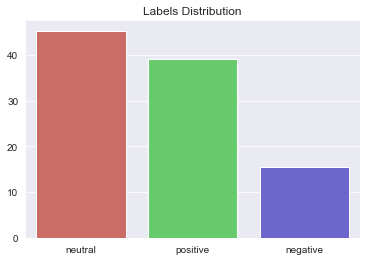

In [24]:
sns.set_style('darkgrid')
labelperc = sns.barplot(labelcounts.index, labelcounts.values, palette = 'hls')
labelperc.set_title("Labels Distribution")

Label Density Histogram

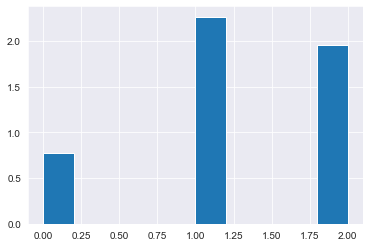

In [25]:
plt.hist(train['labels'], density=True)
plt.show()

## Text Processing & Cleaning

#### Each step here is for exploration purpose at the moment on Sentiment Analysis task only and does not necessarily apply to the other two tasks (Hate Speech Detection and Emotion Recognition)

In [70]:
# Using a subset of train data for experimental purpose and reviewing
train_subset = train['text'].to_list()[:60]
len(train_subset)

60

In [27]:
train_subset[:30]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin" ',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ" ',
 'Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night. ',
 "Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays ",
 '@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017" ',
 "@user LIT MY MUM 'Kerry the louboutins I wonder how many Willam owns!!! Look Kerry Warner Wednesday!' ",
 '"\\"""" SOUL TRAIN\\"""" OCT 27 HALLOWEEN SPECIAL ft T.dot FINEST rocking the mic...CRAZY CACTUS NIGHT CLUB ..ADV ticket $10 wt out costume $15..." ',
 'So disappointed in wwe summerslam! I want to see john cena wins his 16th title ',
 '"This is the last Sunday w/o football .....,

In [28]:
# unicode escape characters found.

for text in train_subset:
    for t in text.split(" "):
        if '\\u' in t:
            print(t)

can\u2019t
he\u2019ll
red\u002c
there\u002c
guys\u002c
Priest\u2019s
We\u2019re
now\u002c
can\u2019t
Don\u2019t
Colbert\u2019s


In [29]:
# Using codec registry I've replaced the unicode characters to their respective ascii characters

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        t =  str.replace(t, '\\u2019', "'")
        t =  str.replace(t, '\u002c', ",")
        new_text.append(t)
    return " ".join(new_text)

In [30]:
print('Raw :', train_subset[12])
print('Cleaned :',preprocess(train_subset[12]))

Raw : Super excited for homecoming Saturday with Monroe! :D my new nephew is here but I can\u2019t see him :( 
Cleaned : Super excited for homecoming Saturday with Monroe! :D my new nephew is here but I can't see him :( 


### Stop Words Removal

In [46]:
from nltk.corpus import stopwords

def stop_words(text_list):
    stop = stopwords.words('english')
    newlist = list(map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]), text_list))
    return newlist

In [66]:
#train_subset = stop_words(train_subet)
stop_words(train_subset[:5])

['"QT @user In original draft 7th book, Remus Lupin survived Battle Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains lineup Thursday, Curtis #NHL #SJ"',
 'Sorry bout stream last night I crashed tonight sure. Then back Minecraft pc tomorrow night.',
 "Chase Headley's RBI double 8th inning David Price snapped Yankees streak 33 consecutive scoreless innings Blue Jays",
 '@user Alciato: Bee invest 150 million January, another 200 Summer plans bring Messi 2017"']

In [48]:
import string

def trans(s):
    '''Remove punctuation'''
    exclude = set(string.punctuation)
    if len(s) > 2:
        t = ''.join(ch for ch in s if ch not in exclude and len(s) > 2)
    else:
        t = s
    return t

### Removing Punctuations (does not work in our tweets data)

Raw Texts

In [61]:
train_subset[9:13]

["@user @user CENA & AJ sitting in a tree K-I-S-S-I-N-G 1st goes AJ's  job then John's cred then goes Vicki with the GM position. ",
 '@user Well said on HMW. Can you now address why Texans fans file out of the stadium midway through the 4th qtr of every game? ',
 "Just said hello to Dennis Kucinich as he walked casually through campus with his #hotwife. He's on 22nd st! ",
 'Super excited for homecoming Saturday with Monroe! :D my new nephew is here but I can\\u2019t see him :( ']

After Removing

In [62]:
list(map(trans, train_subset[9:13]))

['user user CENA  AJ sitting in a tree KISSING 1st goes AJs  job then Johns cred then goes Vicki with the GM position ',
 'user Well said on HMW Can you now address why Texans fans file out of the stadium midway through the 4th qtr of every game ',
 'Just said hello to Dennis Kucinich as he walked casually through campus with his hotwife Hes on 22nd st ',
 'Super excited for homecoming Saturday with Monroe D my new nephew is here but I canu2019t see him  ']

### Stemming

In [63]:
from nltk.stem import PorterStemmer

def stemming(text_list):
    ps = PorterStemmer()
    newlist = list(map(lambda x: ' '.join([ps.stem(word) for word in x.split()]), text_list))
    return newlist

In [64]:
#train_subset = stemming(train_subet)
stemming(train_subset[:5])

['"qt @user In the origin draft of the 7th book, remu lupin surviv the battl of hogwarts. #happybirthdayremuslupin"',
 '"ben smith / smith (concussion) remain out of the lineup thursday, curti #nhl #sj"',
 'sorri bout the stream last night I crash out but will be on tonight for sure. then back to minecraft in pc tomorrow night.',
 "chase headley' rbi doubl in the 8th inning off david price snap a yanke streak of 33 consecut scoreless inning against blue jay",
 '@user alciato: bee will invest 150 million in january, anoth 200 in the summer and plan to bring messi by 2017"']

### Lemmatization

In [67]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizing(text_list):
    lmtzr = WordNetLemmatizer()
    newlist = list(map(lambda x: ' '.join([lmtzr.lemmatize(word, 'v') for word in x.split()]), text_list))
    return newlist

In [68]:
#train_subset = lemmatizing(train_subset)
lemmatizing(train_subset[:5])

['"QT @user In the original draft of the 7th book, Remus Lupin survive the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remain out of the lineup Thursday, Curtis #NHL #SJ"',
 'Sorry bout the stream last night I crash out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.',
 "Chase Headley's RBI double in the 8th inning off David Price snap a Yankees streak of 33 consecutive scoreless innings against Blue Jays",
 '@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plan to bring Messi by 2017"']

### Let's use RoBERTa pre-trained Model to do Sentiment Analysis on our test dataset

#### We only need to install one dependnecy: the transformers library.

In [1]:
!pip install transformers

#### Getting familiar with Transformer based Models to acheive tasks

In [ ]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict

MODEL = "cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

def get_embedding(text):
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  features = model(**encoded_input)
  features = features[0].detach().cpu().numpy() 
  features_mean = np.mean(features[0], axis=0) 
  return features_mean

MODEL = "cardiffnlp/twitter-roberta-base"

query = "The book was awesome"

tweets = ["I just ordered fried chicken 🐣", 
          "The movie was great", 
          "What time is the next game?", 
          "Just finished reading 'Embeddings in NLP'"]

d = defaultdict(int)
for tweet in tweets:
  sim = 1-cosine(get_embedding(query),get_embedding(tweet))
  d[tweet] = sim

print('Most similar to: ',query)
print('----------------------------------------')
for idx,x in enumerate(sorted(d.items(), key=lambda x:x[1], reverse=True)):
  print(idx+1,x[0])

In [80]:
test_subset = data_loader('test_text.txt', False)[:5]

Tokenizing with Max_length = 32; Padding to 'longest' isn't a good idea unless you have super powerful machine

In [82]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import numpy as np

MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

#encoded_input = tokenizer(test_subset, padding='longest', return_tensors='pt')['input_ids']
encoded_input = tokenizer(test_subset, max_length=32, padding=True, return_tensors='pt')['input_ids']

In [83]:
output = model(encoded_input)

output

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.3165,  0.6184, -2.0770],
        [-0.9789,  1.2316, -0.0624],
        [ 1.2620,  0.7443, -2.0546],
        [-3.3268,  1.1320,  2.2390],
        [ 0.1234,  0.4451, -0.5329]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

#### Wow! so it was this simple. using pretrained model, we have already got logits (classification scores before softmax). stay tuned...

In [85]:
output[0]

tensor([[ 1.3165,  0.6184, -2.0770],
        [-0.9789,  1.2316, -0.0624],
        [ 1.2620,  0.7443, -2.0546],
        [-3.3268,  1.1320,  2.2390],
        [ 0.1234,  0.4451, -0.5329]], grad_fn=<AddmmBackward>)

In [86]:
scores = output[0].detach().numpy()
scores

array([[ 1.3164916 ,  0.6184199 , -2.076978  ],
       [-0.9788736 ,  1.2315959 , -0.06238552],
       [ 1.2620112 ,  0.74428296, -2.0546472 ],
       [-3.3268366 ,  1.1320405 ,  2.2389865 ],
       [ 0.12336496,  0.44510543, -0.53289545]], dtype=float32)

#### Applying softmax

In [87]:
scores_soft = softmax(scores)
scores_soft

array([[0.11650047, 0.05796409, 0.00391348],
       [0.01173446, 0.10701829, 0.02934195],
       [0.11032327, 0.06573863, 0.00400185],
       [0.00112139, 0.09687721, 0.2930638 ],
       [0.03533128, 0.04874045, 0.01832943]], dtype=float32)

In [93]:
predicted_labels = []
for scores in scores_soft:
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    predicted_labels.append(ranking[0])

In [94]:
predicted_labels

[0, 1, 0, 2, 1]

In [95]:
test_df = pd.DataFrame({'text': test_subset, 'predicted_labels': predicted_labels})

In [97]:
test_df['pred_label_text'] = test_df['predicted_labels'].map(mapping['labels'].to_dict())

#### Here we go :) Ignore the text at index 1 :p

In [99]:
test_df[:5]

,text,predicted_labels,pred_label_text
0,@user @user what do these '1/2 naked pics' hav...,0,negative
1,OH: “I had a blue penis while I was this” [pla...,1,neutral
2,"@user @user That's coming, but I think the vic...",0,negative
3,I think I may be finally in with the in crowd ...,2,positive
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",1,neutral


#### Bye for now.. See you later!